In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.datasets import sunspots
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.statespace.structural import UnobservedComponents
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Input, Add, Activation, LayerNormalization, Dense
import time
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')


# Load a small sample from the Monthly M4 data (first 3 series)
train_df = pd.read_csv("m4/Monthly-train.csv")
test_df = pd.read_csv("m4/Monthly-test.csv")
metadata_df = pd.read_csv("m4/m4_info.csv")

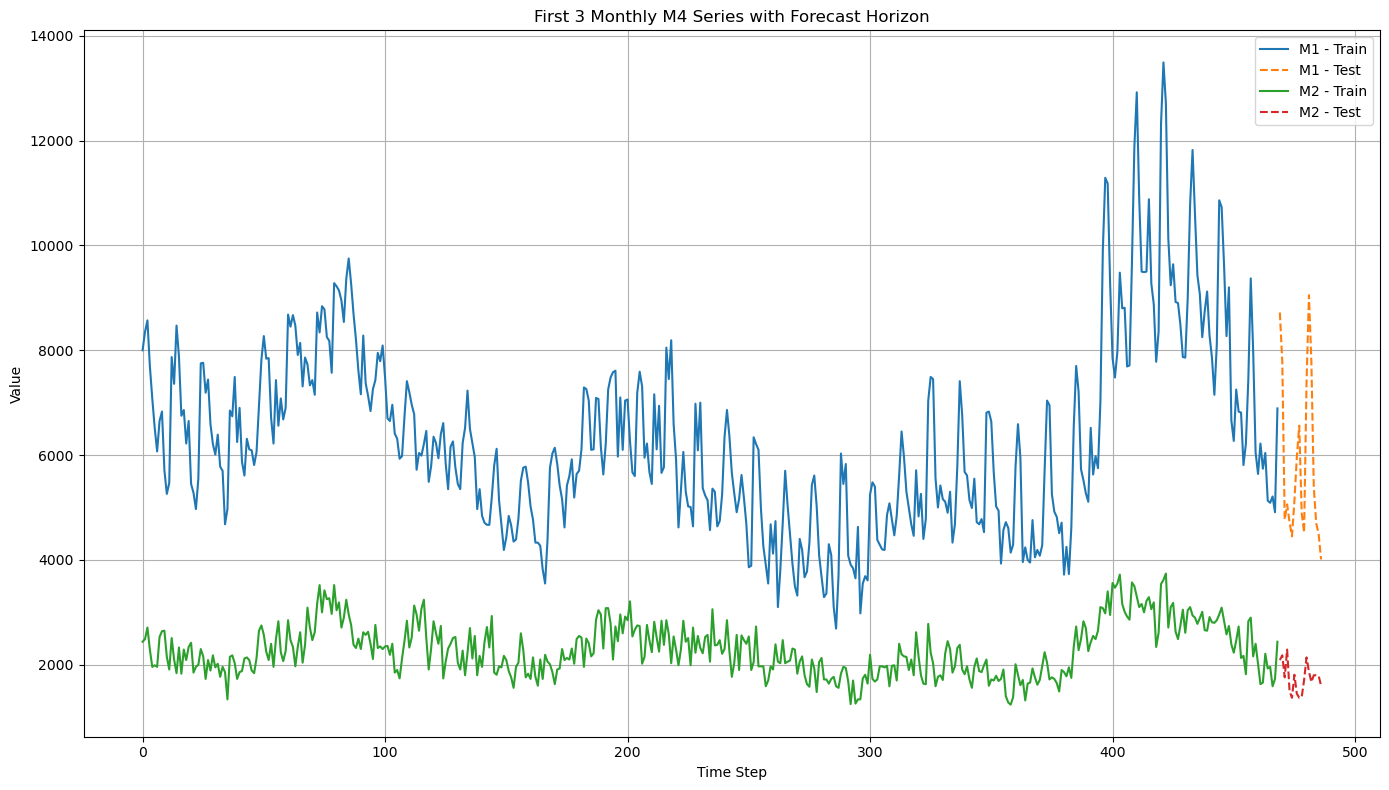

In [2]:
# Plot the first 3 series
plt.figure(figsize=(14, 8))
for i in range(2):
    series_id = train_df.iloc[i, 0]
    train_values = train_df.iloc[i, 1:].dropna().values
    test_values = test_df[test_df.iloc[:, 0] == series_id].iloc[0, 1:].dropna().values
    full_series = list(train_values) + list(test_values)
    
    plt.plot(range(len(train_values)), train_values, label=f"{series_id} - Train", linestyle='-')
    plt.plot(range(len(train_values), len(full_series)), test_values, label=f"{series_id} - Test", linestyle='--')

plt.title("First 3 Monthly M4 Series with Forecast Horizon")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# ARIMA training and prediction
def train_arima(train_data, order=(1, 1, 1)):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    return model_fit

def predict_arima(model_fit, train_data, steps):
    in_sample = model_fit.predict(start=1, end=len(train_data)-1, typ='levels')
    residuals = train_data[1:] - in_sample
    sigma = np.std(residuals)
    lower_in = in_sample - 1.96 * sigma
    upper_in = in_sample + 1.96 * sigma
    forecast_result = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    lower_out = forecast_ci[:, 0]
    upper_out = forecast_ci[:, 1]
    return in_sample, lower_in, upper_in, forecast_mean, lower_out, upper_out

In [4]:
# SARIMA training and prediction functions
def train_sarima(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train_data,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    return model_fit

def predict_sarima(model_fit, train_data, steps):
    train_pred_result = model_fit.get_prediction(start=1, end=len(train_data)-1, dynamic=False)
    train_mean = train_pred_result.predicted_mean
    train_ci = train_pred_result.conf_int()
    lower_in = train_ci[:, 0]
    upper_in = train_ci[:, 1]

    forecast_result = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    lower_out = forecast_ci[:, 0]
    upper_out = forecast_ci[:, 1]

    return train_mean, lower_in, upper_in, forecast_mean, lower_out, upper_out

In [5]:
# Holt-Winters training and prediction functions
def train_holtwinters(train_data, trend='add', seasonal='add', seasonal_periods=12):
    model = ExponentialSmoothing(
        train_data,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    )
    model_fit = model.fit()
    return model_fit

def predict_holtwinters(model_fit, train_data, steps):
    train_pred = model_fit.fittedvalues
    residuals = train_data - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    forecast = model_fit.forecast(steps=steps)
    lower_out = forecast - 1.96 * sigma
    upper_out = forecast + 1.96 * sigma

    return train_pred, lower_in, upper_in, forecast, lower_out, upper_out

In [6]:
# Prophet training and prediction functions
def train_prophet(train_data, train_index):
    df = pd.DataFrame({
        'ds': train_index,
        'y': train_data
    })
    model = Prophet(yearly_seasonality=True)
    model.fit(df)
    return model

def predict_prophet(model_fit, train_data, test_data, train_index, test_index):
    df_train = pd.DataFrame({'ds': train_index, 'y': train_data})
    df_test = pd.DataFrame({'ds': test_index})
    future = pd.concat([df_train[['ds']], df_test], ignore_index=True)

    forecast = model_fit.predict(future)
    forecast.set_index('ds', inplace=True)

    # Extract predictions
    train_pred = forecast.loc[train_index, 'yhat']
    lower_in = forecast.loc[train_index, 'yhat_lower']
    upper_in = forecast.loc[train_index, 'yhat_upper']

    test_pred = forecast.loc[test_index, 'yhat']
    lower_out = forecast.loc[test_index, 'yhat_lower']
    upper_out = forecast.loc[test_index, 'yhat_upper']

    return train_pred.values, lower_in.values, upper_in.values, test_pred.values, lower_out.values, upper_out.values


In [7]:
# DLM training and prediction
def train_dlm(train_data, seasonal_period=12):
    model = UnobservedComponents(train_data, level='local level', seasonal=seasonal_period)
    model_fit = model.fit(disp=False)
    return model_fit

def predict_dlm(model_fit, train_data, steps):
    train_result = model_fit.get_prediction()
    train_pred = train_result.predicted_mean
    train_ci = train_result.conf_int()
    lower_in = train_ci[:, 0] if isinstance(train_ci, np.ndarray) else train_ci.iloc[:, 0].to_numpy()
    upper_in = train_ci[:, 1] if isinstance(train_ci, np.ndarray) else train_ci.iloc[:, 1].to_numpy()

    forecast_result = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    lower_out = forecast_ci[:, 0] if isinstance(forecast_ci, np.ndarray) else forecast_ci.iloc[:, 0].to_numpy()
    upper_out = forecast_ci[:, 1] if isinstance(forecast_ci, np.ndarray) else forecast_ci.iloc[:, 1].to_numpy()

    return train_pred, lower_in, upper_in, forecast_mean, lower_out, upper_out


In [8]:
# RNN training and prediction
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

def train_rnn(train_data, look_back=12, epochs=20):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

def predict_rnn(model, train_data, test_data, look_back=12):
    # In-sample prediction
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    # Forecasting
    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)

In [9]:
# LSTM training function
def train_lstm(train_data, look_back=12, epochs=20):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# LSTM prediction function
def predict_lstm(model, train_data, test_data, look_back=12):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    # Forecast step by step
    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)

In [10]:
# GRU training function
def train_gru(train_data, look_back=12, epochs=20):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    model = Sequential([
        GRU(50, activation='tanh', input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# GRU prediction function
def predict_gru(model, train_data, test_data, look_back=12):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)

In [11]:
"""
# Build custom TCN model function
def build_custom_tcn(input_shape, filters=64, kernel_size=3, dilations=[1, 2, 4, 8]):
    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilations:
        shortcut = x
        x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
        x = LayerNormalization()(x)
        x = Activation('relu')(x)
        x = Add()([shortcut, x])  # Residual connection
    x = Dense(1)(x[:, -1, :])  # Output only from last time step
    return Model(inputs, x)

# Train TCN
def train_tcn(train_data, look_back=12, epochs=100):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    model = build_custom_tcn((look_back, 1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# Predict TCN
def predict_tcn(model, train_data, test_data, look_back=12):
    X_train, y_train = create_sequences(train_data, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred = model.predict(X_train, verbose=0).flatten()
    residuals = y_train - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    history = list(train_data[-look_back:])
    test_pred, lower_out, upper_out = [], [], []
    for _ in range(len(test_data)):
        input_seq = np.array(history[-look_back:]).reshape((1, look_back, 1))
        pred = model.predict(input_seq, verbose=0)[0, 0]
        test_pred.append(pred)
        lower_out.append(pred - 1.96 * sigma)
        upper_out.append(pred + 1.96 * sigma)
        history.append(pred)

    return train_pred, lower_in, upper_in, np.array(test_pred), np.array(lower_out), np.array(upper_out)
"""

"\n# Build custom TCN model function\ndef build_custom_tcn(input_shape, filters=64, kernel_size=3, dilations=[1, 2, 4, 8]):\n    inputs = Input(shape=input_shape)\n    x = inputs\n    for dilation_rate in dilations:\n        shortcut = x\n        x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)\n        x = LayerNormalization()(x)\n        x = Activation('relu')(x)\n        x = Add()([shortcut, x])  # Residual connection\n    x = Dense(1)(x[:, -1, :])  # Output only from last time step\n    return Model(inputs, x)\n\n# Train TCN\ndef train_tcn(train_data, look_back=12, epochs=100):\n    X_train, y_train = create_sequences(train_data, look_back)\n    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))\n    model = build_custom_tcn((look_back, 1))\n    model.compile(optimizer='adam', loss='mse')\n    model.fit(X_train, y_train, epochs=epochs, verbose=0)\n    return model\n\n# Predict TCN\ndef predict_tcn(model, train_data, test_data, look_

In [12]:
# Multi-step TCN model
def build_custom_tcn_multi(input_shape, output_steps, filters=64, kernel_size=3, dilations=[1, 2, 4, 8]):
    inputs = Input(shape=input_shape)
    x = inputs
    for dilation_rate in dilations:
        shortcut = x
        x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
        x = LayerNormalization()(x)
        x = Activation('relu')(x)
        x = Add()([shortcut, x])
    x = Dense(output_steps)(x[:, -1, :])
    return Model(inputs, x)

# Create input-output sequence pairs
def create_multi_output_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i + input_len])
        y.append(data[i + input_len:i + input_len + output_len])
    return np.array(X), np.array(y)

# Train TCN
def train_tcn(train_data, look_back=12, output_steps=18, epochs=20):
    X_train, y_train = create_multi_output_sequences(train_data, look_back, output_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    model = build_custom_tcn_multi((look_back, 1), output_steps)
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model

# Predict TCN
def predict_tcn(model, train_data, test_data, look_back=12):
    forecast_horizon = len(test_data)

    # In-sample: only first step prediction for error estimation
    X_train, y_train = create_multi_output_sequences(train_data, look_back, forecast_horizon)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    train_pred_full = model.predict(X_train, verbose=0)
    train_pred = train_pred_full[:, 0]

    residuals = y_train[:, 0] - train_pred
    sigma = np.std(residuals)
    lower_in = train_pred - 1.96 * sigma
    upper_in = train_pred + 1.96 * sigma

    # Forecast entire horizon
    input_seq = np.array(train_data[-look_back:]).reshape((1, look_back, 1))
    test_pred = model.predict(input_seq, verbose=0)[0]
    lower_out = test_pred - 1.96 * sigma
    upper_out = test_pred + 1.96 * sigma

    return train_pred, lower_in, upper_in, test_pred, lower_out, upper_out

In [13]:
# Evaluation function
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "sMAPE": smape
    }

In [14]:
# Extended wrapper to also collect training and prediction times
def train_and_predict_wrapper(model_name, train_data, test_data, train_index=None, test_index=None):
    start_train = time.time()
    if model_name == "ARIMA":
        model_fit = train_arima(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_arima(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "SARIMA":
        model_fit = train_sarima(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_sarima(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "Holt-Winters":
        model_fit = train_holtwinters(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_holtwinters(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "Prophet":
        model_fit = train_prophet(train_data, train_index)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_prophet(model_fit, train_data, test_data, train_index, test_index)
        pred_time = time.time() - start_pred
    elif model_name == "DLM":
        model_fit = train_dlm(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_dlm(model_fit, train_data, len(test_data))
        pred_time = time.time() - start_pred
    elif model_name == "RNN":
        model_fit = train_rnn(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_rnn(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    elif model_name == "LSTM":
        model_fit = train_lstm(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_lstm(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    elif model_name == "GRU":
        model_fit = train_gru(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_gru(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    elif model_name == "TCN":
        model_fit = train_tcn(train_data)
        train_time = time.time() - start_train
        start_pred = time.time()
        _, _, _, test_pred, _, _ = predict_tcn(model_fit, train_data, test_data)
        pred_time = time.time() - start_pred
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    return test_pred, train_time, pred_time

In [15]:
# Plotting function
def plot_forecast(train_data, test_data, train_index, test_index,
                  train_pred, train_lower, train_upper,
                  test_pred, test_lower, test_upper,
                  model_name="Model", dataset_name="Dataset",
                  show_train_ci=True, show_test_ci=True):

    plt.figure(figsize=(12, 6))
    plt.plot(train_index, train_data, label=f'{dataset_name} Train (True)', linestyle=':', color='black')
    plt.plot(test_index, test_data, label=f'{dataset_name} Test (True)', color='gray')
    aligned_train_index = train_index[-len(train_pred):]
    plt.plot(aligned_train_index, train_pred, label=f'{model_name} Train Prediction', color='green')
    if show_train_ci:
        plt.fill_between(aligned_train_index, train_lower, train_upper, color='green', alpha=0.2, label=f'{model_name} Train 95% CI')
    plt.plot(test_index, test_pred, label=f'{model_name} Test Forecast', color='blue')
    if show_test_ci:
        plt.fill_between(test_index, test_lower, test_upper, color='blue', alpha=0.2, label=f'{model_name} Test 95% CI')
    plt.axvline(test_index[0], color='gray', linestyle='--', label='Train/Test Split')
    plt.title(f'{model_name} Forecast with CI on {dataset_name}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
# Modified benchmark function to use external train_and_predict_wrapper
def benchmark_m4_final(models, train_df, test_df, metadata_df, max_series=None):
    results = []

    # Create lookup for fast category access
    category_lookup = dict(zip(metadata_df["M4id"], metadata_df["category"]))

    n_series = len(train_df) if max_series is None else min(max_series, len(train_df))

    for i in range(n_series):
        series_id = train_df.iloc[i, 0]
        train_data = train_df.iloc[i, 1:].dropna().values.astype(float)
        test_data = test_df[test_df.iloc[:, 0] == series_id].iloc[0, 1:].dropna().values.astype(float)
        category = category_lookup.get(series_id, "Unknown")

        # Create synthetic datetime indices (needed by Prophet)
        train_index = pd.date_range(start="2000-01-01", periods=len(train_data), freq="M")
        test_index = pd.date_range(start=train_index[-1] + pd.DateOffset(months=1), periods=len(test_data), freq="M")

        for model in models:
            try:
                test_pred, train_time, pred_time = train_and_predict_wrapper(
                    model, train_data, test_data, train_index, test_index
                )
                metrics = evaluate_forecast(test_data, test_pred)
                results.append({
                    "Series ID": series_id,
                    "Category": category,
                    "Train Size": len(train_data),
                    "Test Size": len(test_data),
                    "Model": model,
                    "Train Time (s)": train_time,
                    "Predict Time (s)": pred_time,
                    **metrics
                })
            except Exception as e:
                print(f"Error with {model} on {series_id}: {e}")
    return pd.DataFrame(results)


In [17]:
# Helper function to compute STL-based features
def extract_time_series_features(series, seasonal_period=12):
    result = STL(series, period=seasonal_period, robust=True).fit()
    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid
    series_var = np.var(trend + resid)

    trend_strength = 1 - (np.var(resid) / np.var(trend + resid)) if np.var(trend + resid) != 0 else 0
    seasonality_strength = 1 - (np.var(resid) / np.var(seasonal + resid)) if np.var(seasonal + resid) != 0 else 0
    noise_level = np.std(resid)

    return trend_strength, seasonality_strength, noise_level

# Modified benchmark function with time series features
def benchmark_m4_with_features(models, train_df, test_df, metadata_df, max_series=None):
    results = []

    category_lookup = dict(zip(metadata_df["M4id"], metadata_df["category"]))

    n_series = len(train_df) if max_series is None else min(max_series, len(train_df))

    for i in range(n_series):
        series_id = train_df.iloc[i, 0]
        train_data = train_df.iloc[i, 1:].dropna().values.astype(float)
        test_data = test_df[test_df.iloc[:, 0] == series_id].iloc[0, 1:].dropna().values.astype(float)
        category = category_lookup.get(series_id, "Unknown")

        # Time index (for Prophet)
        train_index = pd.date_range(start="2000-01-01", periods=len(train_data), freq="M")
        test_index = pd.date_range(start=train_index[-1] + pd.DateOffset(months=1), periods=len(test_data), freq="M")

        # Extract features from training series
        try:
            trend_strength, seasonality_strength, noise_level = extract_time_series_features(train_data)
        except Exception as e:
            print(f"Feature extraction failed for {series_id}: {e}")
            trend_strength, seasonality_strength, noise_level = None, None, None

        for model in models:
            try:
                test_pred, train_time, pred_time = train_and_predict_wrapper(
                    model, train_data, test_data, train_index, test_index
                )
                metrics = evaluate_forecast(test_data, test_pred)
                results.append({
                    "Series ID": series_id,
                    "Category": category,
                    "Train Size": len(train_data),
                    "Test Size": len(test_data),
                    "Model": model,
                    "Train Time (s)": train_time,
                    "Predict Time (s)": pred_time,
                    "Trend Strength": trend_strength,
                    "Seasonality Strength": seasonality_strength,
                    "Noise Level": noise_level,
                    **metrics
                })
            except Exception as e:
                print(f"Error with {model} on {series_id}: {e}")
    return pd.DataFrame(results)

#models = ["ARIMA"] 
#
#results = benchmark_m4_with_features(models, train_df, test_df, metadata_df, max_series=2)
#results

In [18]:
# Re-imports after code execution state reset
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import time

# STL-based feature extraction
def extract_time_series_features(series, seasonal_period=12):
    result = STL(series, period=seasonal_period, robust=True).fit()
    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid

    trend_strength = 1 - (np.var(resid) / np.var(trend + resid)) if np.var(trend + resid) != 0 else 0
    seasonality_strength = 1 - (np.var(resid) / np.var(seasonal + resid)) if np.var(seasonal + resid) != 0 else 0
    noise_level = np.std(resid)

    return trend_strength, seasonality_strength, noise_level

# Sample n time series per category
def sample_series_per_category(metadata_df, n=10, freq="Monthly", random_state=42):
    sampled_ids = []
    monthly_df = metadata_df[metadata_df["SP"] == freq]
    for cat in monthly_df["category"].unique():
        ids = monthly_df[monthly_df["category"] == cat]["M4id"].sample(n=n, random_state=random_state).tolist()
        sampled_ids.extend(ids)
    return sampled_ids

# Final benchmark function using sampled time series
def benchmark_m4_with_features_and_sampling(models, train_df, test_df, metadata_df, n_per_category=10):
    results = []
    category_lookup = dict(zip(metadata_df["M4id"], metadata_df["category"]))
    selected_ids = sample_series_per_category(metadata_df, n=n_per_category)

    # Filter train and test
    train_df_filtered = train_df[train_df.iloc[:, 0].isin(selected_ids)]
    test_df_filtered = test_df[test_df.iloc[:, 0].isin(selected_ids)]

    for i in range(len(train_df_filtered)):
        series_id = train_df_filtered.iloc[i, 0]
        train_data = train_df_filtered.iloc[i, 1:].dropna().values.astype(float)
        test_data = test_df_filtered[test_df_filtered.iloc[:, 0] == series_id].iloc[0, 1:].dropna().values.astype(float)
        category = category_lookup.get(series_id, "Unknown")

        # Create synthetic datetime index (for Prophet)
        train_index = pd.date_range(start="2000-01-01", periods=len(train_data), freq="M")
        test_index = pd.date_range(start=train_index[-1] + pd.DateOffset(months=1), periods=len(test_data), freq="M")

        # STL features
        try:
            trend_strength, seasonality_strength, noise_level = extract_time_series_features(train_data)
        except Exception as e:
            print(f"Feature extraction failed for {series_id}: {e}")
            trend_strength, seasonality_strength, noise_level = None, None, None

        for model in models:
            try:
                test_pred, train_time, pred_time = train_and_predict_wrapper(
                    model, train_data, test_data, train_index, test_index
                )
                metrics = evaluate_forecast(test_data, test_pred)
                results.append({
                    "Series ID": series_id,
                    "Category": category,
                    "Train Size": len(train_data),
                    "Test Size": len(test_data),
                    "Model": model,
                    "Train Time (s)": train_time,
                    "Predict Time (s)": pred_time,
                    "Trend Strength": trend_strength,
                    "Seasonality Strength": seasonality_strength,
                    "Noise Level": noise_level,
                    **metrics
                })
            except Exception as e:
                print(f"Error with {model} on {series_id}: {e}")
    return pd.DataFrame(results)


In [19]:
import os
import pandas as pd

def benchmark_m4_with_features_and_sampling(models, train_df, test_df, metadata_df, n_per_category=10, save_path="results.csv"):
    results = []
    save_interval = 10
    iteration_counter = 0

    # Load existing results if available
    if os.path.exists(save_path):
        existing_results = pd.read_csv(save_path)
        done_set = set(zip(existing_results["Series ID"], existing_results["Model"]))
    else:
        existing_results = pd.DataFrame()
        done_set = set()

    category_lookup = dict(zip(metadata_df["M4id"], metadata_df["category"]))
    selected_ids = sample_series_per_category(metadata_df, n=n_per_category)

    train_df_filtered = train_df[train_df.iloc[:, 0].isin(selected_ids)]
    test_df_filtered = test_df[test_df.iloc[:, 0].isin(selected_ids)]

    for i in range(len(train_df_filtered)):
        series_id = train_df_filtered.iloc[i, 0]
        train_data = train_df_filtered.iloc[i, 1:].dropna().values.astype(float)
        test_data = test_df_filtered[test_df_filtered.iloc[:, 0] == series_id].iloc[0, 1:].dropna().values.astype(float)
        category = category_lookup.get(series_id, "Unknown")

        train_index = pd.date_range(start="2000-01-01", periods=len(train_data), freq="M")
        test_index = pd.date_range(start=train_index[-1] + pd.DateOffset(months=1), periods=len(test_data), freq="M")

        try:
            trend_strength, seasonality_strength, noise_level = extract_time_series_features(train_data)
        except Exception as e:
            print(f"Feature extraction failed for {series_id}: {e}")
            trend_strength, seasonality_strength, noise_level = None, None, None

        for model in models:
            if (series_id, model) in done_set:
                print(f"Skipping already completed {model} on {series_id}")
                continue

            try:
                test_pred, train_time, pred_time = train_and_predict_wrapper(
                    model, train_data, test_data, train_index, test_index
                )
                metrics = evaluate_forecast(test_data, test_pred)
                result = {
                    "Series ID": series_id,
                    "Category": category,
                    "Train Size": len(train_data),
                    "Test Size": len(test_data),
                    "Model": model,
                    "Train Time (s)": train_time,
                    "Predict Time (s)": pred_time,
                    "Trend Strength": trend_strength,
                    "Seasonality Strength": seasonality_strength,
                    "Noise Level": noise_level,
                    **metrics
                }
                results.append(result)
                done_set.add((series_id, model))
                iteration_counter += 1

                # Save every 5 iterations
                if iteration_counter % save_interval == 0:
                    df = pd.DataFrame(results)
                    combined = pd.concat([existing_results, df], ignore_index=True)
                    combined.to_csv(save_path, index=False)
                    print(f"Saved intermediate results at iteration {iteration_counter}")
                    results = []  # clear local results after saving
                    existing_results = combined

            except Exception as e:
                print(f"Error with {model} on {series_id}: {e}")

    # Save any remaining results
    if results:
        df = pd.DataFrame(results)
        combined = pd.concat([existing_results, df], ignore_index=True)
        combined.to_csv(save_path, index=False)
        print(f"Final save completed.")
        
    return combined


In [20]:
models = [
    "ARIMA",         # (p,d,q) = (1,1,1)
    "SARIMA",        # (1,1,1)(1,1,1,12)
    "Holt-Winters",  # trend='add', seasonal='add', seasonal_periods=12
    #"Prophet",       # default config, yearly seasonality if len(series) > 365
    "DLM",           # trend + seasonal (period=12)
    "RNN",           # look_back=12, units=50, epochs=20
    "LSTM",          # look_back=12, units=50, epochs=20
    "GRU",           # look_back=12, units=50, epochs=20
    "TCN"            # filters=64, kernel_size=3, dilations=[1,2,4,8]
]

results_df = benchmark_m4_with_features_and_sampling(
    models=models,
    train_df=train_df,
    test_df=test_df,
    metadata_df=metadata_df,
    n_per_category=100
)


Skipping already completed ARIMA on M36
Skipping already completed SARIMA on M36
Skipping already completed Holt-Winters on M36
Skipping already completed DLM on M36
Skipping already completed RNN on M36
Skipping already completed LSTM on M36
Skipping already completed GRU on M36
Skipping already completed TCN on M36
Skipping already completed ARIMA on M40
Skipping already completed SARIMA on M40
Skipping already completed Holt-Winters on M40
Skipping already completed DLM on M40
Skipping already completed RNN on M40
Skipping already completed LSTM on M40
Skipping already completed GRU on M40
Skipping already completed TCN on M40
Skipping already completed ARIMA on M81
Skipping already completed SARIMA on M81
Skipping already completed Holt-Winters on M81
Skipping already completed DLM on M81
Skipping already completed RNN on M81
Skipping already completed LSTM on M81
Skipping already completed GRU on M81
Skipping already completed TCN on M81
Skipping already completed ARIMA on M451
Sk

In [21]:
results_df

,Series ID,Category,Train Size,Test Size,Model,Train Time (s),Predict Time (s),Trend Strength,Seasonality Strength,Noise Level,MAE,RMSE,MAPE,sMAPE
0,M1091,Macro,306,18,ARIMA,0.035867,0.001589,0.979647,0.930031,12.364398,99.994345,107.802060,9.867230,10.465362
1,M1618,Macro,330,18,ARIMA,0.032786,0.001160,0.887737,0.316813,250.639385,115.771922,139.235757,18.252091,16.841791
2,M2169,Macro,306,18,ARIMA,0.028377,0.001155,0.997841,0.286580,29.153653,39.832863,52.443534,1.919695,1.888419
3,M2311,Macro,306,18,ARIMA,0.024523,0.001205,0.980328,-0.076245,44.116194,11.088616,17.131600,0.798600,0.805988
4,M5958,Macro,359,18,ARIMA,0.014173,0.001954,0.910211,0.285343,2047.352170,2710.224667,3284.918942,35.255438,27.220157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,M47998,Other,118,18,DLM,0.025078,0.001045,0.430021,0.176835,345.432431,161.222624,193.157905,3.248530,3.197149
4796,M47998,Other,118,18,RNN,3.089534,0.929412,0.430021,0.176835,345.432431,4985.727145,4986.971845,99.992299,199.952151
4797,M47998,Other,118,18,LSTM,1.501141,0.975864,0.430021,0.176835,345.432431,4985.706291,4986.949867,99.991901,199.967608
4798,M47998,Other,118,18,GRU,1.832158,0.978695,0.430021,0.176835,345.432431,4985.454179,4986.696099,99.986881,199.947545
